# Operator overloading in python

In [1]:
class Planet:
    def __init__(self, moons):
        self.moons = moons
    
    def __add__(self, newplanet):
        newmoons = self.moons + newplanet.moons
        return Planet(moons=newmoons)

In [2]:
p1 = Planet(['Gany', 'Titan'])
p2 = Planet(['phobo', 'dimo'])

In [3]:
p3 = p1+p2

In [4]:
p3.moons

['Gany', 'Titan', 'phobo', 'dimo']

# GPcore Tests

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
try:
    restartkernel()
except:
    pass

In [2]:
# %load_ext autoreload
# %autoreload 2

import sys, os
sys.path.append(os.path.abspath('..'))

from condensate.core import gpcore
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
import time
import pandas as pd
from scipy.ndimage import rotate as rotate_image

todo:
- epsilon-omega movie frames
- movie save
- mouse
- data save - python full wrapper
- growth rates
- ring potential - edge states (set V?)
- bdg
- timedependent v
- 

In [3]:

omega = 10.

hbar = 1.05e-34
omegaz = 10
mass = 3.8e-26
a0 = 5.3e-11
a_s = 100*a0
N = 2e5
g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))

Rxy = np.sqrt(15 * N * a_s * np.sqrt(mass * omegaz / hbar))
a_h = np.sqrt(hbar / (2*mass *omega))
lb = np.sqrt(hbar / (mass *omega))
fov = 7 * Rxy * a_h
fov = 900 * 1e-6

In [3]:
1e6*lb

16.62274915510922

In [4]:
# g = 0

In [5]:
DIM = 512
x = (1+0.j)*np.zeros((DIM,DIM))
V = np.zeros((DIM,DIM))
width = 10
for i in range(DIM):
    for j in range(DIM):
        x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
        

gpcore.Setup(DIM, fov, g, 2e-3,  True, 0.001)

gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
gpcore.GetPotential(V)

# plt.contour(V)
# plt.gca().set_aspect('equal', 'box')
# plt.show()

gpcore.Evolve(x,1000,40, True, 3e8)

In [22]:
xrelax = x.copy()

# 1D rotini

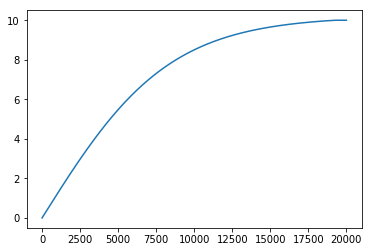

In [23]:
whirrMax = omega

steps = 20000
times = np.arange(steps)
whirrtime = 20000

# Omega = whirrMax* np.ones(steps)
Omega = [np.min([whirrMax, omega * 1.02 * np.tanh(2.4 * t / whirrtime)]) for t in times]

plt.plot(times, Omega)

In [24]:
x = xrelax.copy()
gpcore.Setup(DIM, fov, g, 2e-4, False, 0.000)

gpcore.SetHarmonicPotential(omega,0.18) #omega, epsilon
gpcore.RotatingFrame(Omega)
gpcore.AbsorbingBoundaryConditions(1,600e-6)

gpcore.Evolve(x, steps, 50, True, 2e7)

In [25]:
gpcore.Setup(DIM, fov, g, 2e-4, False, 0.00)
steps = 10000
Omega = whirrMax* np.ones(steps)
gpcore.SetHarmonicPotential(omega,0) #omega, epsilon
gpcore.RotatingFrame(Omega)
gpcore.AbsorbingBoundaryConditions(1,600e-6)

gpcore.Evolve(x, steps, 50, True, 2e7)

# 1D growths

In [130]:
stepslist = np.arange(0,20000,1000)

In [131]:
stepslist

array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000, 19000])

In [152]:
glist = 9.275086005434142e-40 * np.array([0,0.0001, 0.001,0.01,0.02,0.03,0.04,0.05,0.1,1])

columns = ['g', 'steps', 'Psi']
results1d = pd.DataFrame(columns=columns)


for g in tqdm(glist):
    
    DIM = 512
    x = (1+0.j)*np.zeros((DIM,DIM))
    V = np.zeros((DIM,DIM))
    width = 10
    for i in range(DIM):
        for j in range(DIM):
            x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j


    gpcore.Setup(DIM, fov, g, 2e-3,  True, 0.001)

    gpcore.SetHarmonicPotential(omega,0.0) 

    gpcore.Evolve(x,1000,40, True, 3e8)
    
    whirrMax = omega

#     if g<0.03:
#         steps = 30000
#     else:
    steps = 30000
    whirrtime = 20000
    times = np.arange(steps)

    Omega = [np.min([whirrMax, omega * 1.02 * np.tanh(2.4 * t / whirrtime)]) for t in times]
    gpcore.Setup(DIM, fov, g, 2e-4, False, 0.000)
    gpcore.SetHarmonicPotential(omega,0.18) #omega, epsilon
    gpcore.RotatingFrame(Omega)
    gpcore.AbsorbingBoundaryConditions(1,600e-6)
    gpcore.Evolve(x, steps, 500, True, 1e8)
    
    for steps in tqdm(stepslist, leave=False):
        gpcore.Setup(DIM, fov, g, 1e-3, False, 0.00)
        Omega = whirrMax* np.ones(1000)
        gpcore.SetHarmonicPotential(omega,0) #omega, epsilon
        gpcore.RotatingFrame(Omega)
        gpcore.AbsorbingBoundaryConditions(1,600e-6)
        gpcore.Evolve(x, 1000, 50, True, 7e6)
        
        Psi = x.copy()
        newresults = pd.DataFrame([[g,steps,Psi]],columns=columns)
        results1d = results1d.append(newresults,  ignore_index=True)

In [138]:
ntest = np.abs(results1d.iloc[10].Psi)**2

In [139]:

view = 250

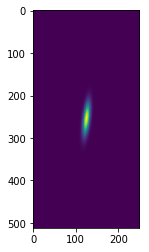

In [140]:
plt.imshow(rotate_image(ntest,-45, reshape=False)[: , 256-view//2 : 256+ view//2])

In [153]:
finalplot = []
view = 250
for i,r in results1d.iterrows():
    density = rotate_image(np.abs(r.Psi)**2,-45,reshape=False)[: , 256-view//2 : 256+ view//2]
    finalplot.append(density)

In [154]:
np.sum(alls[0,:,:,:])

6472691358159.912

In [155]:
alls = np.reshape(finalplot, [ len(glist),len(stepslist), 512, view])
last = np.vstack([np.hstack(alls[i,:,:,:]/np.sum(alls[i,:,:,:])) for i in range(len(glist))])

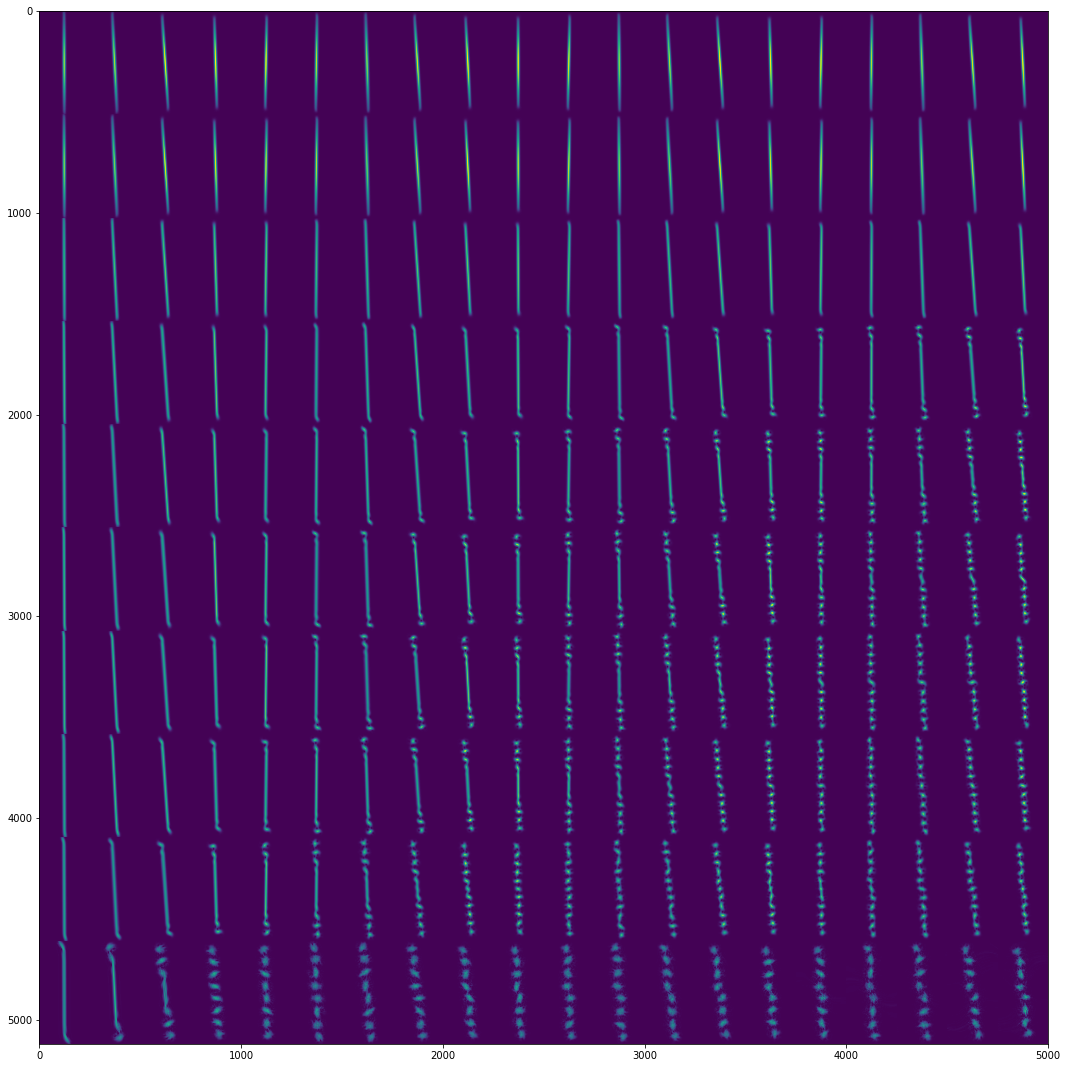

In [156]:
plt.figure(figsize=(19,19))
plt.imshow(last)
plt.savefig('./1dgrowths_2.png')

(-40, 40)

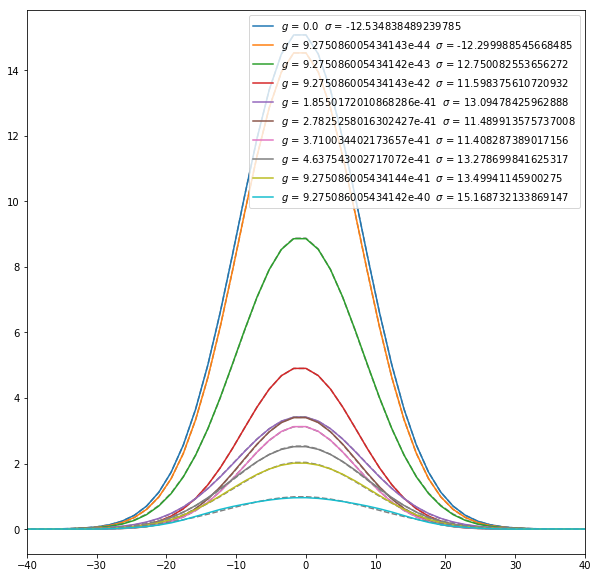

In [158]:
plt.figure(figsize=(10,10))
for i,r in results1d.iterrows():
    if r.steps==0:
        x = dx * np.arange(-view//2,view//2,1)
        density = rotate_image(np.abs(r.Psi)**2,-45,reshape=False)[256-view//2 : 256+ view//2 , 256-view//2 : 256+ view//2]
        f,_ = curve_fit(gauss, 1e6*x, 1e-9*np.sum(density, axis=0), [0,2,16])
        plt.plot(1e6*x,gauss(1e6*x,*f),'--', color='grey')
        plt.plot(1e6*x,1e-9*np.sum(density, axis=0), '-',label='$g$ = ' + str(r.g) + '  $\sigma$ = ' + str(f[2]))
        
plt.legend()
plt.xlim(-40 , 40)

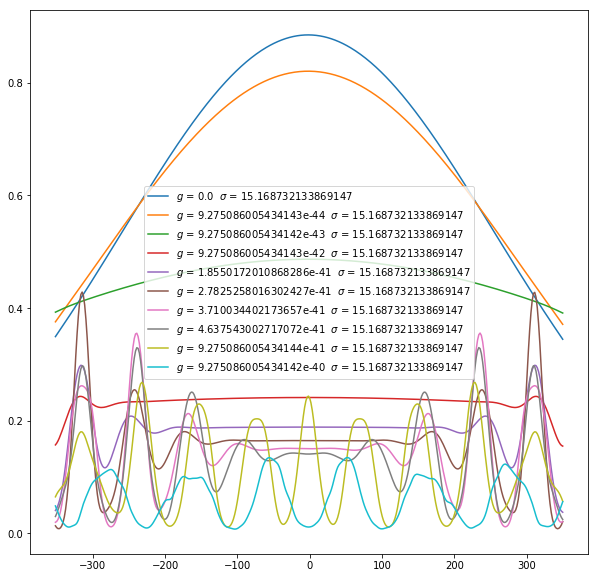

In [163]:
view=400
plt.figure(figsize=(10,10))
for i,r in results1d.iterrows():
    if r.steps==10000:
        x = dx * np.arange(-view//2,view//2,1)
        density = rotate_image(np.abs(r.Psi)**2,-45,reshape=False)[256-view//2 : 256+ view//2 , 256-view//2 : 256+ view//2]
        plt.plot(1e6*x,1e-9*np.sum(density, axis=1), '-',label='$g$ = ' + str(r.g) + '  $\sigma$ = ' + str(f[2]))
        
plt.legend()
# plt.xlim(-40 , 40)

In [89]:
def gauss(x,x0,a,s): return a*np.exp(- (x-x0) **2 / (s**2))

In [90]:
from scipy.optimize import curve_fit

In [93]:
f

array([-0.89377604,  0.55568644, 12.42994597])

In [91]:
f,_ = curve_fit(gauss, 1e6*x, 1e-9*np.sum(density, axis=0), [0,2,16])

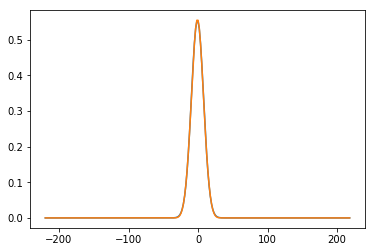

In [92]:
plt.plot(1e6*x,gauss(1e6*x,*f))
plt.plot(1e6*x, 1e-9*np.sum(density, axis=0))

In [76]:
lb*1e6

16.62274915510922

In [69]:
len(density)

250

In [62]:
dx = 900e-6 / 512

In [68]:
x

array([0.00000000e+00, 1.75781250e-06, 3.51562500e-06, ...,
       2.55999996e+02, 2.55999997e+02, 2.55999999e+02])

In [63]:
view

250

# 2D Rotini

In [5]:

omega = 10.

hbar = 1.05e-34
omegaz = 10
mass = 3.8e-26
a0 = 5.3e-11
a_s = 100*a0
N = 2e5
g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))

Rxy = np.sqrt(15 * N * a_s * np.sqrt(mass * omegaz / hbar))
a_h = np.sqrt(hbar / (2*mass *omega))
lb = np.sqrt(hbar / (mass *omega))
fov = 7 * Rxy * a_h
fov = 900 * 1e-6

DIM = 512
x = (1+0.j)*np.zeros((DIM,DIM))
V = np.zeros((DIM,DIM))
width = 10
for i in range(DIM):
    for j in range(DIM):
        x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
        

gpcore.Setup(DIM, fov, g, 2e-3,  True, 0.001)

gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
gpcore.GetPotential(V)

# plt.contour(V)
# plt.gca().set_aspect('equal', 'box')
# plt.show()

gpcore.Evolve(x,1000,40, True, 3e8)
xrelax=x.copy()

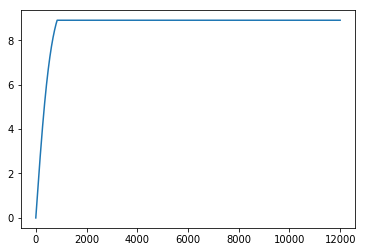

In [6]:
whirrMax = 0.89*omega

steps = 12000
times = np.arange(steps)
whirrtime = 1500

# Omega = whirrMax* np.ones(steps)
Omega = [np.min([whirrMax, omega * 1.02 * np.tanh(2.4 * t / whirrtime)]) for t in times]

plt.plot(times, Omega)

In [7]:
x = xrelax.copy()
gpcore.Setup(DIM, fov, g, 1e-3, False, 0.005)

gpcore.SetHarmonicPotential(omega,0.18) #omega, epsilon
gpcore.RotatingFrame(Omega)
gpcore.AbsorbingBoundaryConditions(1,500e-6)

gpcore.Evolve(x, steps, 50, True, 0.8e8)

In [758]:
# # back to circ
# steps = 3500
# Omega = whirrMax* np.ones(steps)
# gpcore.Setup(DIM, fov, g, 1e-3, False, 0.0001)

# gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
# gpcore.RotatingFrame(Omega)

# gpcore.Evolve(x, steps, 50, True, 1e8)

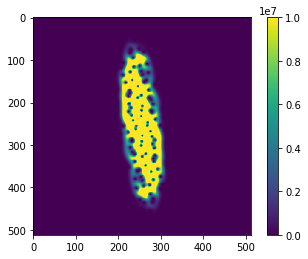

In [9]:
# plt.figure(figsize=(18,18))
plt.imshow(np.abs(x)**2, vmax=1e7)
plt.colorbar()

plt.show()

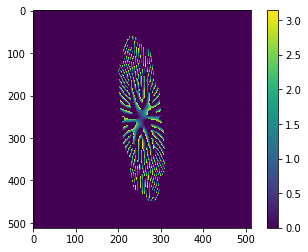

In [10]:
# plt.figure(figsize=(18,18))
plt.imshow(np.angle(x)* (np.abs(x)**2 >1e6), vmin=0)
plt.colorbar()

plt.show()

# epsilon-omega

In [41]:
def compute_rotini(Omega=0.9, epsilon=0.16, steps=15000, show=True, frames=60):
    steps = frames*(steps//frames)
    times = np.arange(steps)
    whirrtime = 1500
    whirrMax = Omega*omega
    Omega = [np.min([whirrMax, omega * 1.02 * np.tanh(2.4 * t / whirrtime)]) for t in times]
    x = xrelax.copy()
    out = []
    for i in range(frames):
        runtime = steps//frames
        gpcore.Setup(DIM, fov, g, 1e-3, False, 0.007)
        gpcore.SetHarmonicPotential(omega,epsilon) #omega, epsilon
        gpcore.RotatingFrame(Omega[i*runtime : (i+1)*runtime])
        gpcore.AbsorbingBoundaryConditions(1,500e-6)
        gpcore.Evolve(x, runtime , 50, show, 0.3e8)
#         out.append(x.copy())
compress psi here 
    return out

In [42]:
Omegalist = [0.7,0.75,0.8, 0.85, 0.86,0.87, 0.88, 0.89, .9,0.91, .92, .94, .96, 1]
epsilonlist = [0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24]

In [ ]:
columns = ['Omega', 'epsilon', 'steps', 'Psi']
results = pd.DataFrame(columns=columns)

for Omega in tqdm(Omegalist):
    for epsilon in tqdm(epsilonlist, leave=False):
        Psi = compute_rotini(Omega, epsilon)
        newresults = pd.DataFrame([[Omega,epsilon,steps,Psi]],columns=columns)
        results = results.append(newresults,  ignore_index=True)

In [ ]:
results.to_pickle('./epomega_3.pkl')

In [114]:
finalplot = []
view = 250
for i,r in results.iterrows():
    density = np.fliplr(np.abs(r.Psi)**2)
    finalplot.append(density[256-view//2 : 256+ view//2, 256-view//2 : 256+ view//2])

In [115]:
alls = np.reshape(finalplot, [len(Omegalist), len(epsilonlist), view, view])
last = np.hstack([np.vstack(alls[i,:,:,:]) for i in range(len(Omegalist))])

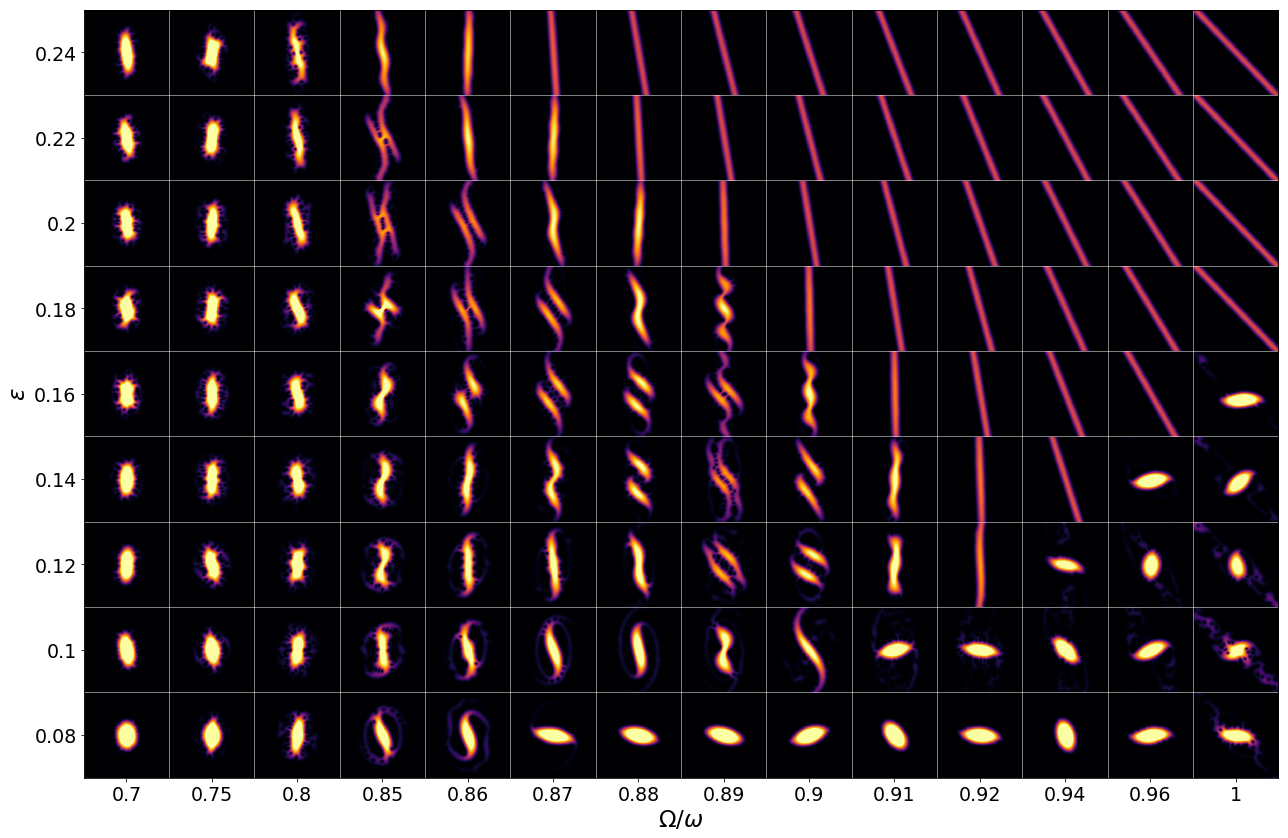

In [117]:
plt.figure(figsize=(18,18))
plt.imshow(last, cmap='inferno',origin='lower', vmax=7e7)
for i in range(len(Omegalist)):
    plt.axvline(i*view, color='w', lw=0.5)
for i in range(len(epsilonlist)):
    plt.axhline(i*view, color='w', lw=0.5)
plt.xticks(np.arange(view//2, len(Omegalist)*view, view), Omegalist) 
plt.yticks(np.arange(view//2, len(epsilonlist)*view, view), epsilonlist) 
plt.gca().tick_params(labelsize=19)
plt.xlabel('$\Omega/\omega$', size=23)
plt.ylabel('$\epsilon$', size=23)
plt.tight_layout()
plt.savefig('epsilon-omega_2.png')
plt.show()

In [15]:
gpcore.Setup(DIM,g, 1e-3,  True, 0.001)
gpcore.SetHarmonicPotential(1,0) 
gpcore.Evolve(x,200,4, True)

gpcore.Setup(DIM,g, 1e-1,  False, 0.001)
gpcore.SetHarmonicPotential(1,0.4) 
gpcore.Evolve(x,9,4, True)

gpcore.Setup(DIM,g, 1e-3,  False, 0.003)
gpcore.SetHarmonicPotential(1,0) 
gpcore.Evolve(x,20000,50, True)

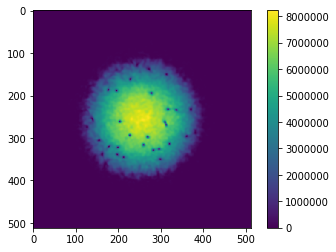

In [38]:
plt.imshow(np.abs(x)**2)
plt.colorbar()

plt.show()

In [39]:
xnew = x.copy()

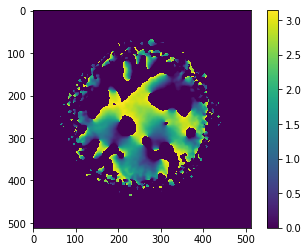

In [40]:
plt.imshow(np.angle(x)* (np.abs(x)**2 >1e4), vmin=0)
plt.colorbar()

plt.show()

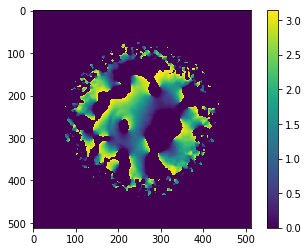

In [41]:
plt.imshow(np.angle(xold)* (np.abs(xold)**2 >1e4), vmin=0)
plt.colorbar()

plt.show()

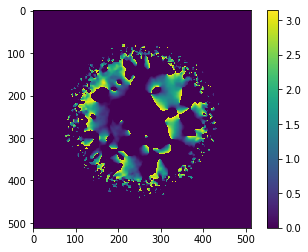

In [42]:
plt.imshow(np.angle(xold/xnew)* (np.abs(xold)**2 >1e4), vmin=0)
plt.colorbar()

plt.show()

In [7]:
dir(gpcore)

['Evolve',
 '__builtin__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_gpcore',
 '_newclass',
 '_object',
 '_swig_getattr',
 '_swig_property',
 '_swig_repr',
 '_swig_setattr',
 '_swig_setattr_nondynamic',
 'cvar',
 'getPotential',
 'setHarmonicPotential',
 'setup']

In [8]:
x = 500e-6
u = 1e-25 * (x**2)

In [10]:
u

2.4999999999999997e-36

# vortex lattice squeezing

In [4]:
omega = 4

hbar = 1.05e-34
omegaz = 10
mass = 3.8e-26
a0 = 5.3e-11
a_s = 100*a0
N = 2e6
g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))

Rxy = np.sqrt(15 * N * a_s * np.sqrt(mass * omegaz / hbar))
a_h = np.sqrt(hbar / (2*mass *omega))
lb = np.sqrt(hbar / (mass *omega))
fov = 7 * Rxy * a_h
fov = 1000 * 1e-6

DIM = 1024
x = (1+0.j)*np.zeros((DIM,DIM))
V = np.zeros((DIM,DIM))
width = 10
for i in range(DIM):
    for j in range(DIM):
        phi = 20*np.arctan2((i-DIM//2), (j-DIM//2))
        phase = np.exp(1.j * np.mod(phi,2*np.pi))
        x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
        x[i,j] *= phase
        

gpcore.Setup(DIM, fov, g, 2e-3,  True, 0.001)
gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon

steps = 6000
Omega = 0.85*omega* np.ones(steps)
gpcore.RotatingFrame(Omega)

# gpcore.GetPotential(V)
# plt.contour(V)
# plt.gca().set_aspect('equal', 'box')
# plt.show()

gpcore.Evolve(x,steps,40, True, 1e7)
xrelax=x.copy()

In [194]:
x = xrelax.copy()
gpcore.Setup(DIM, fov, g, 1e-3,  True, 0.001)

gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
gpcore.GetPotential(V)
steps = 2000
Omega = 0.8*omega* np.ones(steps)
gpcore.SetHarmonicPotential(omega,0) #omega, epsilon
gpcore.RotatingFrame(Omega)


gpcore.Evolve(x,steps,40, True, 1e7)


gpcore.Setup(DIM, fov, g, 5e-4,  False, 0.1)

gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
gpcore.GetPotential(V)
steps = 5000
Omega = 0.8*omega* np.ones(steps)
gpcore.SetHarmonicPotential(omega,0) #omega, epsilon
gpcore.RotatingFrame(Omega)


gpcore.Evolve(x,steps,60, True, 1e7)


gpcore.Setup(DIM, fov, g, 1e-3,  True, 0.001)

gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
gpcore.GetPotential(V)
steps = 2000
Omega = 0.8*omega* np.ones(steps)
gpcore.SetHarmonicPotential(omega,0) #omega, epsilon
gpcore.RotatingFrame(Omega)


gpcore.Evolve(x,steps,40, True, 1e7)


gpcore.Setup(DIM, fov, g, 5e-4,  False, 0.001)

gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
gpcore.GetPotential(V)
steps = 5000
Omega = 0.8*omega* np.ones(steps)
gpcore.SetHarmonicPotential(omega,0) #omega, epsilon
gpcore.RotatingFrame(Omega)


gpcore.Evolve(x,steps,60, True, 1e7)


gpcore.Setup(DIM, fov, g, 1e-3,  True, 0.001)

gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
gpcore.GetPotential(V)
steps = 2000
Omega = 0.8*omega* np.ones(steps)
gpcore.SetHarmonicPotential(omega,0) #omega, epsilon
gpcore.RotatingFrame(Omega)


gpcore.Evolve(x,steps,40, True, 1e7)

In [195]:

gpcore.Setup(DIM, fov, g, 1e-4,  False, 0.001)

gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
gpcore.GetPotential(V)
steps = 20000
Omega = omega* np.ones(steps)
gpcore.SetHarmonicPotential(omega,0.15) #omega, epsilon
gpcore.RotatingFrame(Omega)
gpcore.AbsorbingBoundaryConditions(1,600e-6)

# plt.contour(V)
# plt.gca().set_aspect('equal', 'box')
# plt.show()

gpcore.Evolve(x,steps,40, True, 1e7)

# colormap interpolation

In [6]:
import numpy as np
from matplotlib import cm
from scipy.optimize import curve_fit

def quad(x,a,b,c,d): return d + c*x + b * (x**2) + a * (x**3)

In [7]:
rgb = cm.get_cmap('inferno')
x = np.linspace(0,1,100)
colors = np.array([rgb(xx) for xx in x])

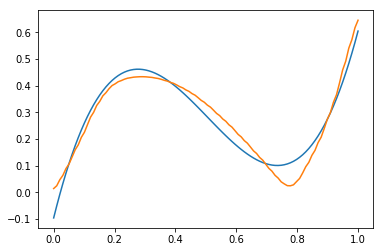

[  7.5327364  -11.43486921   4.60270604  -0.09628023]


In [8]:
channel = 2
f, _  = curve_fit(quad, x, colors[:,channel], [1,1,1,1])
plt.plot(x, quad(x, *f))
plt.plot(x,colors[:,channel])
plt.show()
print(f)